# Proyecto 1: Integración de modelos Naive Bayes y regresión logística multinomial para clasificación multiclase con evaluación

**Integrantes**:

| Apellidos y nombres | Código |
|---------------------|--------|
| Meza Rodriguez, Fiorella Ivonne | 20192730G |
| Murillo Dominguez, Paul Hans | 20193507J |



**Descripción**: Desarrolla un sistema de clasificación de texto que combine modelos generativos (Naive Bayes) y discriminativos (Regresión Logística Multinomial) para tareas de clasificación multiclase, como la categorización de noticias. Implementa técnicas de descenso de gradiente estocástico con mini-lotes y regularización para optimizar los modelos. Evalúa el rendimiento utilizando métricas como precisión, recall, medida F y realiza pruebas de significancia estadística, incluyendo la prueba bootstrap pareada.

**Resultados esperados**:
- Implementación funcional de Naive Bayes y Regresión Logística Multinomial.
- Sistema de clasificación que integra ambos modelos para mejorar la precisión.
- Optimización mediante descenso de gradiente estocástico con mini-lotes y regularización.
- Evaluación exhaustiva utilizando precisión, recall, medida F, y pruebas de significancia.
- Análisis comparativo entre modelos generativos y discriminativos.
- Documentación detallada de la implementación y los resultados.

**Entradas**:
- Conjunto de datos etiquetado para clasificación multiclase (e.g., Reuters News Dataset).
- Parámetros de optimización y regularización.
- Configuraciones para pruebas estadísticas.

**Salidas**:
- Modelos entrenados de Naive Bayes y Regresión Logística Multinomial.
- Reporte de métricas de evaluación (precisión, recall, F1) para cada modelo.
- Resultados de pruebas de significancia estadística.
- Visualizaciones de la convergencia del descenso de gradiente.
- Análisis interpretativo de los modelos.

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss
from sklearn.ensemble import VotingClassifier
from sklearn.utils import resample
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import reuters
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings("ignore")

## 1. Conjunto de datos etiquetado para clasificación multiclase

### 1.1. Descarga del conjunto de datos Reuters News Dataset

In [59]:
nltk.download('wordnet')
nltk.download('reuters')
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### 1.2. Carga y etiquetado de los documentos

In [60]:
def get_documents_and_categories(fileids):
    documents = [reuters.raw(file) for file in fileids]
    categories = [reuters.categories(file) for file in fileids]
    return documents, categories


train_fileids = [file for file in reuters.fileids() if file.startswith('training/')]
test_fileids = [file for file in reuters.fileids() if file.startswith('test/')]

train_documents, train_categories = get_documents_and_categories(train_fileids)
test_documents, test_categories = get_documents_and_categories(test_fileids)

### 1.3. Codificación de las etiquetas

In [61]:
mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(train_categories)
test_labels = mlb.transform(test_categories)

In [62]:
trainDf = pd.DataFrame({"content": train_documents})
testDf = pd.DataFrame({"content": test_documents})

### 1.4. Preprocesamiento de los documentos

In [63]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
import nltk

# Cargar el lematizador y el stemmer
wordnet_lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Cargar las stopwords desde un archivo
stopwords = set(w.rstrip() for w in open('resources/stopwords'))


def tokenize_lemma_stopwords(text):
    # Reemplazar saltos de línea por espacios
    text = text.replace("\n", " ")

    # Tokenizar el texto en palabras
    tokens = nltk.tokenize.word_tokenize(text.lower())

    # Filtrar tokens para mantener solo palabras alfabéticas
    tokens = [t for t in tokens if t.isalpha()]

    # Lematizar las palabras para obtener su forma base
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens]

    # Aplicar stemming a las palabras
    tokens = [stemmer.stem(t) for t in tokens]

    # Eliminar palabras cortas (menos de 3 caracteres)
    tokens = [t for t in tokens if len(t) > 2]

    # Eliminar stopwords
    tokens = [t for t in tokens if t not in stopwords]

    # Unir los tokens en una cadena de texto limpia
    cleanedText = " ".join(tokens)

    return cleanedText


def data_cleaning(df):
    # Crear una copia del DataFrame original
    data = df.copy()

    # Aplicar la función de limpieza a la columna 'content'
    data["content"] = data["content"].apply(tokenize_lemma_stopwords)

    return data

In [64]:
cleanedTrainData = data_cleaning(trainDf)
cleanedTestData = data_cleaning(testDf)

### 1.5. Vectorización de los documentos

In [65]:
vectorizer = TfidfVectorizer()
vectorised_train_documents = vectorizer.fit_transform(cleanedTrainData["content"])
vectorised_test_documents = vectorizer.transform(cleanedTestData["content"])

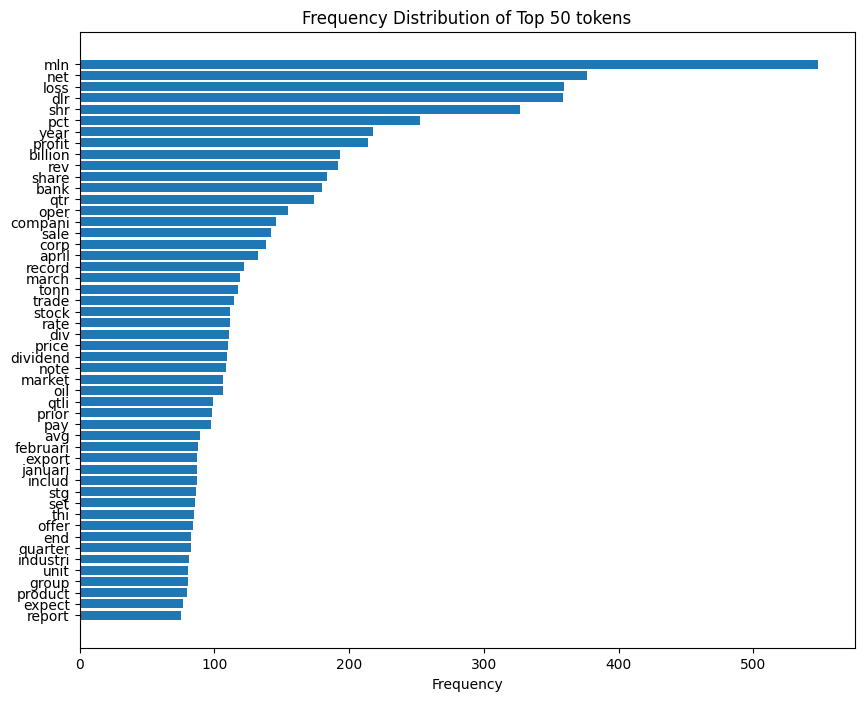

In [66]:
# Suponiendo que `vectorizer` y `vectorised_train_documents` ya están definidos
features = vectorizer.get_feature_names_out()
frequencies = np.asarray(vectorised_train_documents.sum(axis=0)).flatten()

# Ordenar las características por frecuencia
sorted_indices = np.argsort(frequencies)[::-1]
sorted_features = features[sorted_indices]
sorted_frequencies = frequencies[sorted_indices]

# Seleccionar las 50 características más frecuentes
top_n = 50
top_features = sorted_features[:top_n]
top_frequencies = sorted_frequencies[:top_n]

# Crear la gráfica
plt.figure(figsize=(10, 8))
plt.barh(top_features, top_frequencies)
plt.xlabel('Frequency')
plt.title('Frequency Distribution of Top 50 tokens')
plt.gca().invert_yaxis()  # Invertir el eje y para que la característica más frecuente esté en la parte superior
plt.show()

## 2. Implementación de modelos de clasificación

### 2.1. Implementación las métricas de evaluación

### 2.2. Implementación de Naive Bayes

In [67]:
naive_bayes_model = OneVsRestClassifier(MultinomialNB())
naive_bayes_model.fit(vectorised_train_documents, train_labels)


OneVsRestClassifier(estimator=MultinomialNB())

### 2.3. Implementación de Regresión Logística Multinomial

In [68]:
logistic_regression_model = OneVsRestClassifier(
    SGDClassifier(loss='log_loss', penalty='l2', alpha=1e-4, max_iter=1000, tol=1e-3, learning_rate='optimal'))
logistic_regression_model.fit(vectorised_train_documents, train_labels)

OneVsRestClassifier(estimator=SGDClassifier(loss='log_loss'))

### 2.4. Integración de ambos modelos mediante votación

In [69]:
voting_model = OneVsRestClassifier(
    VotingClassifier(estimators=[('nb', naive_bayes_model), ('lr', logistic_regression_model)], voting='soft'))

voting_model.fit(vectorised_train_documents, train_labels)

OneVsRestClassifier(estimator=VotingClassifier(estimators=[('nb',
                                                            OneVsRestClassifier(estimator=MultinomialNB())),
                                                           ('lr',
                                                            OneVsRestClassifier(estimator=SGDClassifier(loss='log_loss')))],
                                               voting='soft'))

## 3. Evaluación de los modelos

In [70]:
ModelsPerformance = {}


def metrics_report(modelName: str, test_labels, predictions) -> None:
    accuracy = accuracy_score(test_labels, predictions)
    macro_precision = precision_score(test_labels, predictions, average='macro')
    macro_recall = recall_score(test_labels, predictions, average='macro')
    macro_f1 = f1_score(test_labels, predictions, average='macro')
    hamLoss = hamming_loss(test_labels, predictions)

    print(f"------{modelName} Model Metrics-----")
    print(
        f"Accuracy: {accuracy:.4f}\nHamming Loss: {hamLoss:.4f}\n"
        f"Precision (Macro): {macro_precision:.4f}\n"
        f"Recall (Macro): {macro_recall:.4f}\n"
        f"F1-measure (Macro): {macro_f1:.4f}"
    )
    ModelsPerformance[modelName] = {
        "accuracy": accuracy,
        "hamming_loss": hamLoss,
        "precision": macro_precision,
        "recall": macro_recall,
        "f1": macro_f1
    }

def bootstrap_paired_test(model1_preds, model2_preds, metric_func, n_bootstrap=1000, random_state=42):
    np.random.seed(random_state)
    boot_diffs = []
    n_samples = model1_preds.shape[0]
    
    for _ in range(n_bootstrap):
        indices = np.random.randint(0, n_samples, n_samples)
        sample1 = model1_preds[indices]
        sample2 = model2_preds[indices]
        metric1 = metric_func(test_labels, sample1)
        metric2 = metric_func(test_labels, sample2)
        boot_diffs.append(metric1 - metric2)
    
    boot_diffs = np.array(boot_diffs)
    mean_diff = np.mean(boot_diffs)
    ci_lower = np.percentile(boot_diffs, 2.5)
    ci_upper = np.percentile(boot_diffs, 97.5)
    p_value = np.mean(boot_diffs > 0)
    
    return mean_diff, ci_lower, ci_upper, p_value

# Definir la métrica a evaluar, por ejemplo, F1-score macro
def f1_macro(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

### 3.1. Evaluación del modelo Naive Bayes

In [71]:
test_predictions_nb = naive_bayes_model.predict(vectorised_test_documents)
metrics_report("Naive Bayes", test_labels, test_predictions_nb)

------Naive Bayes Model Metrics-----
Accuracy: 0.4468
Hamming Loss: 0.0088
Precision (Macro): 0.0555
Recall (Macro): 0.0178
F1-measure (Macro): 0.0222


### 3.2. Evaluación del modelo Regresión Logística Multinomial

In [72]:
test_predictions_lr = logistic_regression_model.predict(vectorised_test_documents)
metrics_report("Logistic Regression", test_labels, test_predictions_lr)

------Logistic Regression Model Metrics-----
Accuracy: 0.7128
Hamming Loss: 0.0049
Precision (Macro): 0.3889
Recall (Macro): 0.1536
F1-measure (Macro): 0.2020


### 3.3. Evaluación del modelo de votación

In [73]:
test_predictions_voting = voting_model.predict(vectorised_test_documents)
metrics_report("Voting", test_labels, test_predictions_voting)

------Voting Model Metrics-----
Accuracy: 0.5661
Hamming Loss: 0.0072
Precision (Macro): 0.1284
Recall (Macro): 0.0350
F1-measure (Macro): 0.0459


In [74]:
print("  Model Name " + " " * 9 + "|  Accuracy  | Hamming Loss | Precision | Recall | F1-measure")
print("------------------------------------------------------------------------------------------")
for key, value in ModelsPerformance.items():
    print(
        f"  {key:20} | {value['accuracy']:.4f} \t| {value['hamming_loss']:.4f} \t| {value['precision']:.4f} \t| {value['recall']:.4f} \t| {value['f1']:.4f}")
    print("------------------------------------------------------------------------------------------")

  Model Name          |  Accuracy  | Hamming Loss | Precision | Recall | F1-measure
------------------------------------------------------------------------------------------
  Naive Bayes          | 0.4468 	| 0.0088 	| 0.0555 	| 0.0178 	| 0.0222
------------------------------------------------------------------------------------------
  Logistic Regression  | 0.7128 	| 0.0049 	| 0.3889 	| 0.1536 	| 0.2020
------------------------------------------------------------------------------------------
  Voting               | 0.5661 	| 0.0072 	| 0.1284 	| 0.0350 	| 0.0459
------------------------------------------------------------------------------------------


In [75]:
# Convertir las predicciones a numpy arrays
test_preds_nb = test_predictions_nb
test_preds_lr = test_predictions_lr
test_preds_voting = test_predictions_voting

# Comparar Naive Bayes vs Logistic Regression
mean_diff, ci_lower, ci_upper, p_value = bootstrap_paired_test(
    test_preds_nb, test_preds_lr, f1_macro
)

print("Bootstrap Paired Test: Naive Bayes vs Logistic Regression")
print(f"Mean Difference (NB - LR): {mean_diff:.4f}")
print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"P-value: {p_value:.4f}")
print("------------------------------------------------------------------------------------------")

# Comparar Logistic Regression vs Voting
mean_diff, ci_lower, ci_upper, p_value = bootstrap_paired_test(
    test_preds_lr, test_preds_voting, f1_macro
)

print("Bootstrap Paired Test: Logistic Regression vs Voting")
print(f"Mean Difference (LR - Voting): {mean_diff:.4f}")
print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"P-value: {p_value:.4f}")
print("------------------------------------------------------------------------------------------")

# Comparar Naive Bayes vs Voting
mean_diff, ci_lower, ci_upper, p_value = bootstrap_paired_test(
    test_preds_nb, test_preds_voting, f1_macro
)

print("Bootstrap Paired Test: Naive Bayes vs Voting")
print(f"Mean Difference (NB - Voting): {mean_diff:.4f}")
print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"P-value: {p_value:.4f}")
print("------------------------------------------------------------------------------------------")


Bootstrap Paired Test: Naive Bayes vs Logistic Regression
Mean Difference (NB - LR): -0.0047
95% CI: [-0.0072, -0.0030]
P-value: 0.0000
------------------------------------------------------------------------------------------
Bootstrap Paired Test: Logistic Regression vs Voting
Mean Difference (LR - Voting): 0.0030
95% CI: [0.0015, 0.0053]
P-value: 1.0000
------------------------------------------------------------------------------------------
Bootstrap Paired Test: Naive Bayes vs Voting
Mean Difference (NB - Voting): -0.0017
95% CI: [-0.0025, -0.0010]
P-value: 0.0000
------------------------------------------------------------------------------------------
